ViT model

In [1]:
# Import necessary libraries
import torchvision
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import timm
from sklearn.metrics import precision_score, recall_score

In [3]:
# Define the custom dataset class
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Set directory containing the dataset
train_dir = r'C:\Users\User\FYP final\Eye dataset 01'

# Prepare the dataset
image_paths = []
labels = []
for label in ['close', 'open']:
    folder = os.path.join(train_dir, label)
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            image_paths.append(os.path.join(folder, filename))
            labels.append(0 if label == 'close' else 1)


In [5]:
# Split the dataset into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)

In [6]:
# Define transformations for training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [7]:
# Create dataset objects
train_dataset = EyeDataset(train_paths, train_labels, transform=train_transform)
val_dataset = EyeDataset(val_paths, val_labels, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [8]:
# Define the Vision Transformer model class
class ViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# Set device to GPU 
device = torch.device('cuda')
model = ViTModel().to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)



d:\ananconda\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [9]:
# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = None

    def __call__(self, val_loss, model, save_path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, save_path):
        self.best_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')


Epoch 1/20: 100%|██████████| 212/212 [01:35<00:00,  2.23batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 109s - accuracy: 57.1344 - loss: 0.8372 - precision: 0.5710 - recall: 0.5713 - val_accuracy: 64.8556 - val_loss: 0.6182 - val_precision: 0.6530 - val_recall: 0.6486 - learning_rate: 1.0000e-03
Validation loss decreased (0.618213 --> 0.618213).  Saving model ...


Epoch 2/20: 100%|██████████| 212/212 [01:33<00:00,  2.26batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 108s - accuracy: 62.7358 - loss: 0.6500 - precision: 0.6276 - recall: 0.6274 - val_accuracy: 67.9505 - val_loss: 0.6170 - val_precision: 0.6900 - val_recall: 0.6795 - learning_rate: 1.0000e-03
EarlyStopping counter: 1 out of 5


Epoch 3/20: 100%|██████████| 212/212 [01:33<00:00,  2.26batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 108s - accuracy: 64.2394 - loss: 0.6332 - precision: 0.6431 - recall: 0.6424 - val_accuracy: 67.0564 - val_loss: 0.6024 - val_precision: 0.7453 - val_recall: 0.6706 - learning_rate: 1.0000e-03
Validation loss decreased (0.602393 --> 0.602393).  Saving model ...


Epoch 4/20: 100%|██████████| 212/212 [01:33<00:00,  2.27batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 107s - accuracy: 68.0719 - loss: 0.5981 - precision: 0.6808 - recall: 0.6807 - val_accuracy: 74.6905 - val_loss: 0.5208 - val_precision: 0.7625 - val_recall: 0.7469 - learning_rate: 1.0000e-03
Validation loss decreased (0.520791 --> 0.520791).  Saving model ...


Epoch 5/20: 100%|██████████| 212/212 [01:32<00:00,  2.28batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 71.7276 - loss: 0.5516 - precision: 0.7173 - recall: 0.7173 - val_accuracy: 76.2036 - val_loss: 0.4799 - val_precision: 0.7645 - val_recall: 0.7620 - learning_rate: 1.0000e-03
Validation loss decreased (0.479920 --> 0.479920).  Saving model ...


Epoch 6/20: 100%|██████████| 212/212 [01:33<00:00,  2.27batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 107s - accuracy: 74.9116 - loss: 0.5176 - precision: 0.7491 - recall: 0.7491 - val_accuracy: 78.7483 - val_loss: 0.4598 - val_precision: 0.7987 - val_recall: 0.7875 - learning_rate: 1.0000e-03
Validation loss decreased (0.459776 --> 0.459776).  Saving model ...


Epoch 7/20: 100%|██████████| 212/212 [01:33<00:00,  2.27batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 107s - accuracy: 77.8007 - loss: 0.4803 - precision: 0.7784 - recall: 0.7780 - val_accuracy: 75.5846 - val_loss: 0.4806 - val_precision: 0.7984 - val_recall: 0.7558 - learning_rate: 1.0000e-03
EarlyStopping counter: 1 out of 5


Epoch 8/20: 100%|██████████| 212/212 [01:33<00:00,  2.27batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 107s - accuracy: 76.9458 - loss: 0.4820 - precision: 0.7695 - recall: 0.7695 - val_accuracy: 77.3040 - val_loss: 0.4875 - val_precision: 0.7807 - val_recall: 0.7730 - learning_rate: 1.0000e-03
EarlyStopping counter: 2 out of 5


Epoch 9/20: 100%|██████████| 212/212 [01:33<00:00,  2.27batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 107s - accuracy: 74.6757 - loss: 0.5217 - precision: 0.7473 - recall: 0.7468 - val_accuracy: 77.6479 - val_loss: 0.4875 - val_precision: 0.7919 - val_recall: 0.7765 - learning_rate: 1.0000e-03
EarlyStopping counter: 3 out of 5


Epoch 10/20: 100%|██████████| 212/212 [01:35<00:00,  2.23batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 109s - accuracy: 74.6167 - loss: 0.5170 - precision: 0.7462 - recall: 0.7462 - val_accuracy: 78.6107 - val_loss: 0.4773 - val_precision: 0.8042 - val_recall: 0.7861 - learning_rate: 1.0000e-04
EarlyStopping counter: 4 out of 5


Epoch 11/20: 100%|██████████| 212/212 [01:37<00:00,  2.19batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 110s - accuracy: 81.4564 - loss: 0.4139 - precision: 0.8150 - recall: 0.8146 - val_accuracy: 83.7001 - val_loss: 0.3938 - val_precision: 0.8422 - val_recall: 0.8370 - learning_rate: 1.0000e-04
Validation loss decreased (0.393793 --> 0.393793).  Saving model ...


Epoch 12/20: 100%|██████████| 212/212 [01:33<00:00,  2.27batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 107s - accuracy: 83.5495 - loss: 0.3940 - precision: 0.8359 - recall: 0.8355 - val_accuracy: 84.3879 - val_loss: 0.3732 - val_precision: 0.8451 - val_recall: 0.8439 - learning_rate: 1.0000e-04
Validation loss decreased (0.373181 --> 0.373181).  Saving model ...


Epoch 13/20: 100%|██████████| 212/212 [01:32<00:00,  2.28batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 83.9917 - loss: 0.3695 - precision: 0.8404 - recall: 0.8399 - val_accuracy: 85.9010 - val_loss: 0.3644 - val_precision: 0.8590 - val_recall: 0.8590 - learning_rate: 1.0000e-04
EarlyStopping counter: 1 out of 5


Epoch 14/20: 100%|██████████| 212/212 [01:32<00:00,  2.28batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 85.2300 - loss: 0.3437 - precision: 0.8526 - recall: 0.8523 - val_accuracy: 85.8322 - val_loss: 0.3412 - val_precision: 0.8618 - val_recall: 0.8583 - learning_rate: 1.0000e-04
Validation loss decreased (0.341217 --> 0.341217).  Saving model ...


Epoch 15/20: 100%|██████████| 212/212 [01:32<00:00,  2.29batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 85.8785 - loss: 0.3264 - precision: 0.8592 - recall: 0.8588 - val_accuracy: 87.3453 - val_loss: 0.3162 - val_precision: 0.8746 - val_recall: 0.8735 - learning_rate: 1.0000e-04
Validation loss decreased (0.316228 --> 0.316228).  Saving model ...


Epoch 16/20: 100%|██████████| 212/212 [01:32<00:00,  2.28batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 86.2618 - loss: 0.3178 - precision: 0.8629 - recall: 0.8626 - val_accuracy: 87.0702 - val_loss: 0.3257 - val_precision: 0.8714 - val_recall: 0.8707 - learning_rate: 1.0000e-04
EarlyStopping counter: 1 out of 5


Epoch 17/20: 100%|██████████| 212/212 [01:33<00:00,  2.27batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 107s - accuracy: 86.8514 - loss: 0.3072 - precision: 0.8686 - recall: 0.8685 - val_accuracy: 86.7263 - val_loss: 0.3129 - val_precision: 0.8674 - val_recall: 0.8673 - learning_rate: 1.0000e-04
EarlyStopping counter: 2 out of 5


Epoch 18/20: 100%|██████████| 212/212 [01:32<00:00,  2.28batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 87.7064 - loss: 0.3041 - precision: 0.8771 - recall: 0.8771 - val_accuracy: 87.8955 - val_loss: 0.2922 - val_precision: 0.8790 - val_recall: 0.8790 - learning_rate: 1.0000e-04
Validation loss decreased (0.292203 --> 0.292203).  Saving model ...


Epoch 19/20: 100%|██████████| 212/212 [01:32<00:00,  2.28batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 88.1191 - loss: 0.2914 - precision: 0.8813 - recall: 0.8812 - val_accuracy: 88.1018 - val_loss: 0.2932 - val_precision: 0.8819 - val_recall: 0.8810 - learning_rate: 1.0000e-04
EarlyStopping counter: 1 out of 5


Epoch 20/20: 100%|██████████| 212/212 [01:32<00:00,  2.28batch/s]


3392/3392 ━━━━━━━━━━━━━━━━━━━━ 106s - accuracy: 88.4139 - loss: 0.2809 - precision: 0.8843 - recall: 0.8841 - val_accuracy: 88.3769 - val_loss: 0.2941 - val_precision: 0.8839 - val_recall: 0.8838 - learning_rate: 1.0000e-04
EarlyStopping counter: 2 out of 5


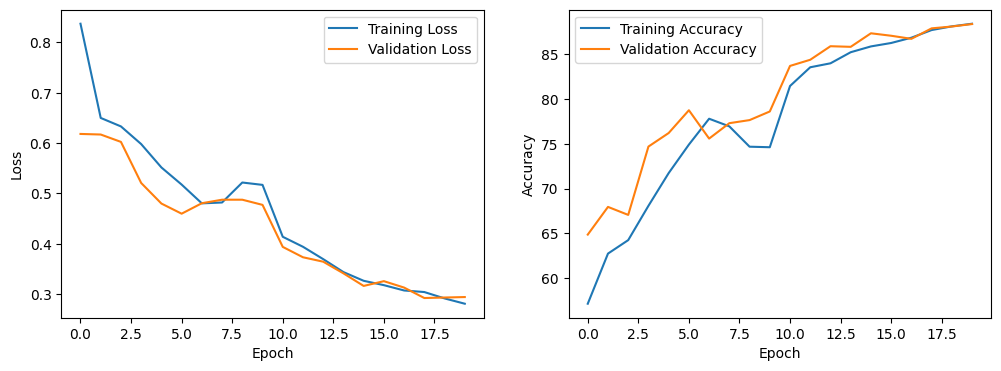

: 

In [4]:
# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, save_dir='pure_vit_model', patience=5):
    os.makedirs(save_dir, exist_ok=True)

    early_stopping = EarlyStopping(patience=patience, delta=0.01)
    save_path = os.path.join(save_dir, 'Vitmodel.pth')

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        all_labels_train = []
        all_preds_train = []

        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            all_labels_train.extend(labels.cpu().numpy())
            all_preds_train.extend(predicted.cpu().numpy())

        train_precision = precision_score(all_labels_train, all_preds_train, average='weighted')
        train_recall = recall_score(all_labels_train, all_preds_train, average='weighted')

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_labels_val = []
        all_preds_val = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_labels_val.extend(labels.cpu().numpy())
                all_preds_val.extend(predicted.cpu().numpy())

        val_precision = precision_score(all_labels_val, all_preds_val, average='weighted')
        val_recall = recall_score(all_labels_val, all_preds_val, average='weighted')

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        scheduler.step(val_loss)

        end_time = time.time()
        elapsed_time = end_time - start_time
        tqdm.write(f"{len(train_loader.dataset)}/{len(train_loader.dataset)} ━━━━━━━━━━━━━━━━━━━━ {elapsed_time:.0f}s - accuracy: {train_accuracy:.4f} - loss: {epoch_loss:.4f} - precision: {train_precision:.4f} - recall: {train_recall:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f} - val_precision: {val_precision:.4f} - val_recall: {val_recall:.4f} - learning_rate: {optimizer.param_groups[0]['lr']:.4e}")

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)

        early_stopping(val_loss, model, save_path)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load(save_path))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5)

In [11]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import numpy as np
import timm

class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

test_dir = r'C:\Users\User\FYP final\test_dataset'

# Load the test dataset
test_paths = []
test_labels = []
for label in ['closed', 'eye']:
    folder = os.path.join(test_dir, label)
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            test_paths.append(os.path.join(folder, filename))
            test_labels.append(0 if label == 'closed' else 1)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = EyeDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and load the model
class ViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTModel().to(device)
model.load_state_dict(torch.load(r'pure_vit_model\ViTmodel.pth'))
model.eval()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluate the model on the test set
all_labels_test = []
all_preds_test = []
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels_test.extend(labels.cpu().numpy())
        all_preds_test.extend(predicted.cpu().numpy())

# Calculate average test loss
test_loss /= len(test_loader)

# Calculate accuracy
test_accuracy = correct / total

# Calculate precision and recall
test_precision = precision_score(all_labels_test, all_preds_test)
test_recall = recall_score(all_labels_test, all_preds_test)

# Print evaluation metrics
print(f'Testing Loss: {test_loss}')
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Precision: {test_precision}')
print(f'Testing Recall: {test_recall}')

Testing Loss: 0.27765755882800214
Testing Accuracy: 0.8883615352868345
Testing Precision: 0.8931641424478101
Testing Recall: 0.8862713241267263


d:\ananconda\envs\gpu\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


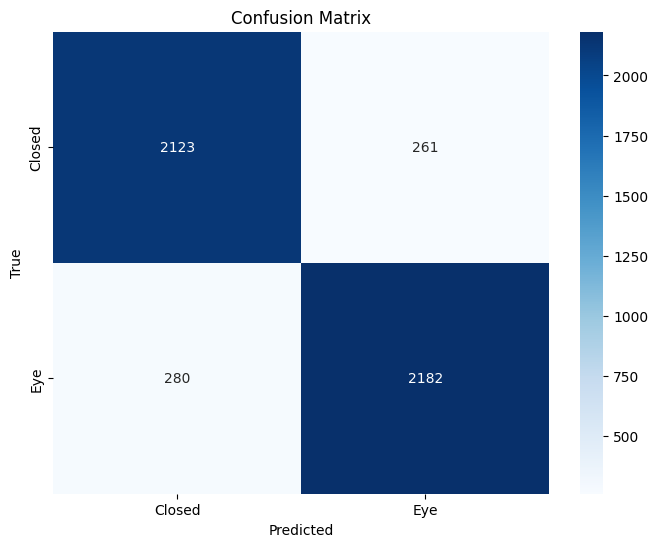

Classification Report:
              precision    recall  f1-score   support

      Closed       0.88      0.89      0.89      2384
         Eye       0.89      0.89      0.89      2462

    accuracy                           0.89      4846
   macro avg       0.89      0.89      0.89      4846
weighted avg       0.89      0.89      0.89      4846



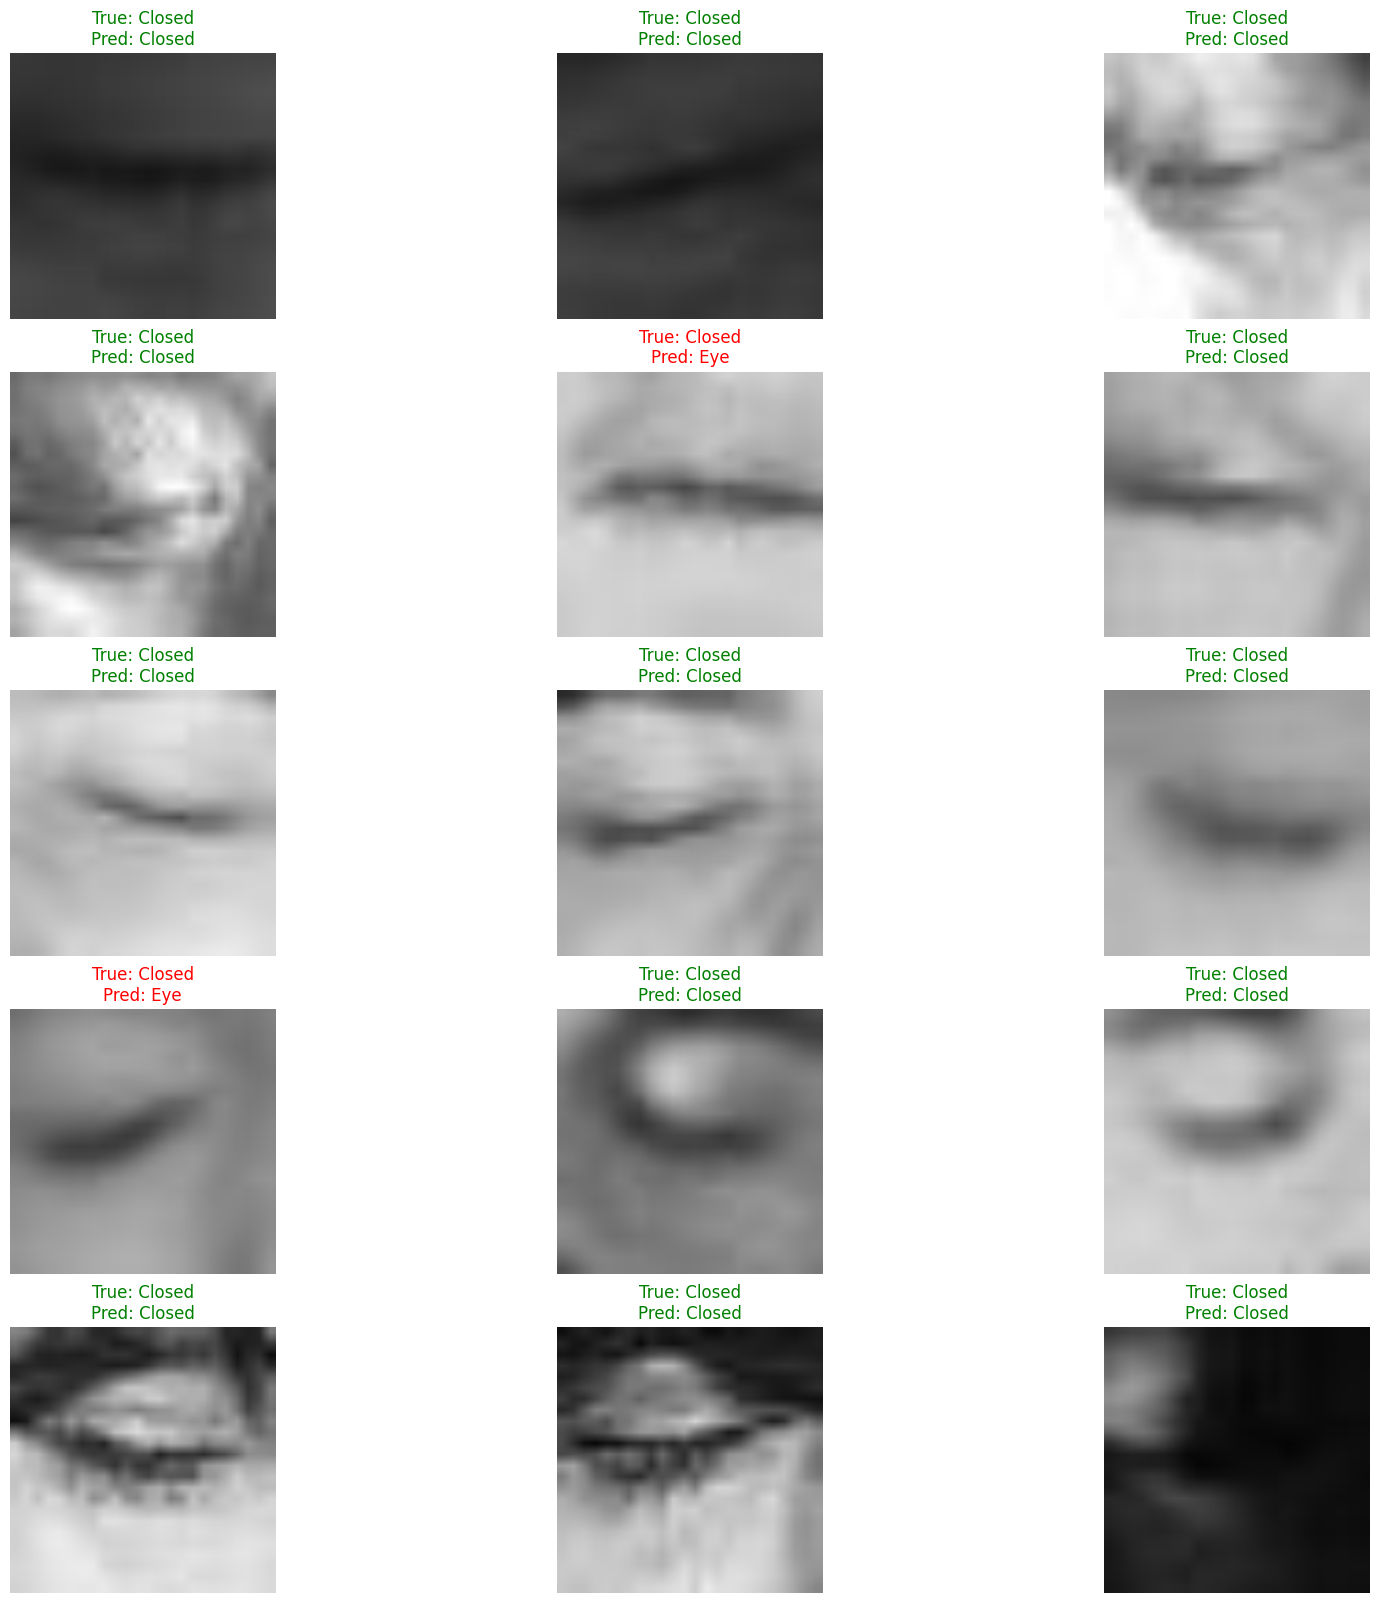

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import timm
import torch.nn as nn

class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

test_dir = r'C:\Users\User\FYP final\test_dataset'

# Load the test dataset
test_paths = []
test_labels = []
for label in ['closed', 'eye']:
    folder = os.path.join(test_dir, label)
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            test_paths.append(os.path.join(folder, filename))
            test_labels.append(0 if label == 'closed' else 1)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = EyeDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and load the model
class ViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTModel().to(device)
model.load_state_dict(torch.load(r'pure_vit_model\ViTmodel.pth'))
model.eval()

# Evaluate the model on the test set
all_labels_test = []
all_preds_test = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels_test.extend(labels.cpu().numpy())
        all_preds_test.extend(predicted.cpu().numpy())

# Generate the confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels_test, all_preds_test)
class_report = classification_report(all_labels_test, all_preds_test, target_names=['Closed', 'Eye'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Eye'], yticklabels=['Closed', 'Eye'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:')
print(class_report)

# Display a few test images with predictions
def display_test_images_with_predictions(dataset, predictions, true_classes, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(15):
        plt.subplot(5, 3, i + 1)
        img, label = dataset[i]
        img = img.permute(1, 2, 0).cpu().numpy()  
        img = (img * 0.5) + 0.5  
        plt.imshow(img)
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predictions[i]]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.show()

class_labels = ['Closed', 'Eye']
display_test_images_with_predictions(test_dataset, all_preds_test, all_labels_test, class_labels)
